In [1]:
# general imports needed by functions
import errno    
import os

# import python scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import needed keras objects into current namespace
from keras import layers
from keras import models
from keras import optimizers


Using TensorFlow backend.


In [2]:
# set plotting visual style and parameters for all plotted figures
%matplotlib inline
sns.set_style('darkgrid') # use seaborn style to improve visual presentation
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (12.0 , 8.0)

In [4]:
import tensorflow as tf

print("is gpu available? ", tf.test.is_gpu_available())
print("")

# check which devices tensorflow has recognized and is using
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

is gpu available?  False

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10231388207842406037
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15122475737541520792
physical_device_desc: "device: XLA_CPU device"
]


# 6.3 Advanced use of recurrent neural networks

Here we look at 3 advanced techniques for RNN.

- *Recurrent dropout* A specific way to use dropout to fight overfitting in recurrent layers
- *Stacking recurrent layers* This increases the representational power of the network.
- *Bidirectional recurrent layers* These present the same information to a recurrent network
  in different ways, increasing accuracy and mitigating forgetting issues.

# 6.3.1 A temperature-forecasting problem

In this example, we use a time series sequence of weather data, rather than NLP data.  This is weather
data recorded from a weather station in Jena Germany.  

In this dataset, 14 different quantities (such as air temperature, atmospheric pressure, humidity,
wind direction, and so on) were recorded every 10 minutes, over several years.  

In these examples, we will build a model that will take several days worth of data points, and learn to
predict the air temperature 24 hours in the future.

We need to download from: https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [5]:
import os

data_dir = 'data'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


The dataset consists of over 420,000 data samples.

Now convert all of the lines of data into a `Numpy` array.

In [6]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Here is the plot of temperature (in degress Celsius) over time.  We can clearly see the yearly periodicity
of the temperature.

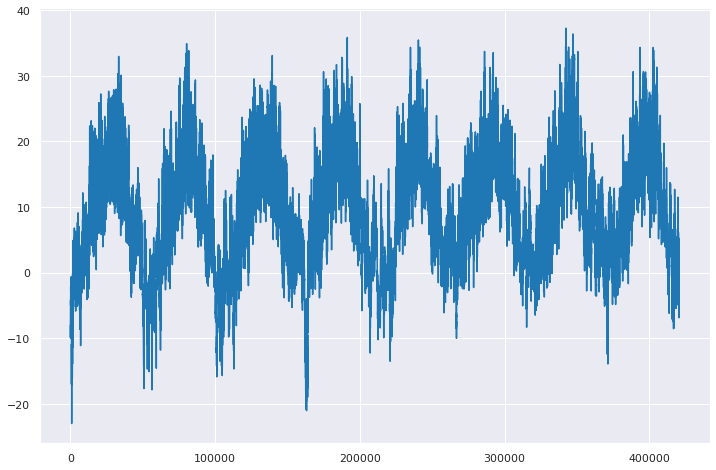

In [7]:
# all 7 years
temp = float_data[:, 1] # col 1 is temperature in degress Celsius
plt.plot(range(len(temp)), temp)

Here is first 10 days of data.  Because data is recorded every 10 minutes, we get 144 data points per day.

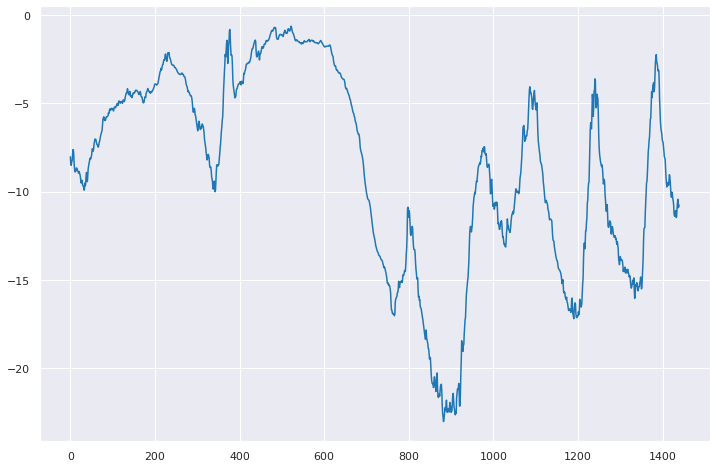

In [8]:
# first 10 days of data
plt.plot(range(1440), temp[:1440])

If we were trying to predict average termperature for the next month given a few past months, the problem would
be easy, due to the reliable year-scale periodicity of the data.  But looking at the data over a scale of days,
the temperature looks a lot more chaotic.  Is this timeseries predictable at a daily scale?  

# 6.3.2 Preparing the data


The exact formulation of the problem will be: given data going as far back as `lookback` timesteps (a timestep is 10
minutes) and sampled every `steps` timesteps, can you predict the temperature in `delay` timesteps?

We will use:

- `lookback` = 720 - Observations will go back 5 days
- `steps` = 6 - Observations will be sampled at one data point per hour
- `delay` = 144 - Targets will be 24 hours in the future


To get started, we need to perform 2 things:

- Preprocess the data to a format a (recurrent) neural network can ingest.
  - Data is already numerical.
  - But each timeseries is on a different scale (temperature ranges from -20 to +30 but pressure is around 1000)
  - So we need to normalize each timeseries independently so that they all take small values on a similar scale.
- Write a generator that takes the current array of float data and yields batches of data from the recent past,
  along with a target temperature in the future.
  - Because samples are highly redundant, we will generate samples on the fly using the original data.
  
We will normalize the data using the straightforward method of subtracting the mean and dividing by the 
standard deviation for each feature.  We will use only the first 200,000 timesteps for the training data,
so we need to compute the mean and sd only on this data (so we don't leak meta-parameter info into our
validation/test results).

In [9]:
num_train = 200000

# subtract means for each feature (axis=0) from all data
mean = float_data[:num_train].mean(axis=0)
float_data -= mean

# likewise, divide by standard deviation of each feature
std = float_data[:num_train].std(axis=0)
float_data /= std

Here we will create the data generator.  It yields a tuple `(samples, targets)`, where `samples` is one
batch of input data and `targets` is the corresponding array of target temperatures.  It takes the
following arguments:

- data - The original array of floating-pont data (after being normalized)
- lookback - How many timesteps back the input data should go
- delay - How many timesteps in the future the target should be
- min_index and max_index - Indices in the data array that delimit which timesteps to draw from.
  This is useful for keeping a segment of the data for validation and another for testing.
- shuffle - Whether to shuffle the samples or draw them in chronological order.
- batch_size - The number of samples per batch.
- step - The period, in timesteps, at which you sample data.  You'll set it to 6 in order to draw
  one data point every hour.

In [10]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    '''Generator for a "data" timeseries.
    
    Parameters
    ----------
    data - The original array of floating-pont data (after being normalized)
    lookback - How many timesteps back the input data should go
    delay - How many timesteps in the future the target should be
    min_index and max_index - Indices in the data array that delimit which timesteps to draw from.
      This is useful for keeping a segment of the data for validation and another for testing.
    shuffle - Whether to shuffle the samples or draw them in chronological order.
    batch_size - The number of samples per batch.
    step - The period, in timesteps, at which you sample data.  You'll set it to 6 in order to draw
      one data point every hour.    
  
    Returns
    -------
    Returns a numpy array of the input samples shape (batch_size, lookback//step, num_features) and another numpy array of
    the targets of shape (batch_size,)
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(
                     min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        # empty numpy array to gather and return the resulting samples we select
        samples = np.zeros((len(rows), 
                           lookback // step,
                           data.shape[-1]))
        
        # likewise, empty array to hold the resulting targets to be returned
        targets = np.zeros((len(rows),))
        
        # rows have been slected (either random or the next batch), extract the input samples and output targets
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            #print(indices)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

We can use this function to instantiate 3 generators, one for training, validation and testing.  Each will
look at different temporal segments of the original data.  Training looks at first 200,000 timesteps.  Validation
looks at next 100,000 and test looks at remainder.

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen =   generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step=step,
                      batch_size=batch_size)

test_gen =  generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step=step,
                      batch_size=batch_size)

# how many steps to draw from val_gen in order to see 
# the entire validation set
# NOTE: looks like bug in book, if you don't divide by batch_size, you will draw WAY too many samples
# to complete a validation
val_steps = (300000 - 200001 - lookback) // batch_size

# how many steps to draw from test_gen in order to see
# the entire test set
# NOTE: ditto, need to divide by batch_size or else draw many more items from test than needed
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# 6.3.3 A common-sense, non-machine-learning baseline

We have talked about a baseline model before.  Before using a complex black-box deep-learning model to solve
the temperature prediciton problem, what is a reasonable performance we could expect to achieve using some simple
common-sense approach.  This will serve as a sanity check, and it will establish a baseline performance that our
more complex model should beat if we consider it to be working at all.

A common-sense first approximation is to always predict that the temperature in 24 hours will be equal to the
current temperature.  Let's evaluate this "prediction" model, using the mean absolute error (MAE) metric:

```python
np.mean(np.abs(preds - targets))
```

Here is how we can calculate the MAE for our validation data, where we always predict that the temperature
will be equal to the last sample temperature.

In [12]:
print(val_steps)

769


In [13]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1] # our naive method is to predict temp is equal to the last temperature in input
        if step % 1000 == 0:
            print(step)
            print(samples.shape)
            print(preds.shape)
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)

mae = evaluate_naive_method()
print(mae)

0
(128, 240, 14)
(128,)
0.2897359729905486


This yields a MAE of 0.29.  Recall that the data we are working with was normalized, so the temperature (like all
other features) has a mean of 0 and a sd of 1.  We can translate it (unnormalize it) by multiplying by the
standard deviation that we divided the data by

In [14]:
celsius_mae = mae * std[1]
print(celsius_mae)

2.564887434980494


This indicates that the MAE is over 2.5 degrees C, which is not bad, but not great.  Now the game is to use
deep learning and RNN to do better.

# 6.3.4 A basic machine-learning approach

In the same way it's useful to establish a common-sense baseline, it also useful to first try a cheap (shallow)
machine-learning model (such as a small, densly connected network). 

We first create a small fully connected model that starts by flatening the data and running it through 2 `Dense`
layers.  Note that this is a regression problem, so we don't use any activation function on the last layer.
We use MAE as the loss.  Because we use the exact same metric as the naive common-sense approach, we can directly
compare this model with the naive prediction.

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [16]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [17]:
model.compile(optimizer=RMSprop(lr=0.0001), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)





Epoch 1/20





500/500 [==============================] - 20s 40ms/step - loss: 0.4361 - val_loss: 0.3777
Epoch 2/20
500/500 [==============================] - 18s 36ms/step - loss: 0.3544 - val_loss: 0.3555
Epoch 3/20
500/500 [==============================] - 18s 36ms/step - loss: 0.3259 - val_loss: 0.4002
Epoch 4/20
500/500 [==============================] - 18s 36ms/step - loss: 0.3053 - val_loss: 0.3410
Epoch 5/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2937 - val_loss: 0.3425
Epoch 6/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2805 - val_loss: 0.3470
Epoch 7/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2719 - val_loss: 0.3716
Epoch 8/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2615 - val_loss: 0.3584
Epoch 9/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2566 - val_loss: 0.3476
Epoch 10/20
500/500 [==============================] - 18s 37ms/step - lo

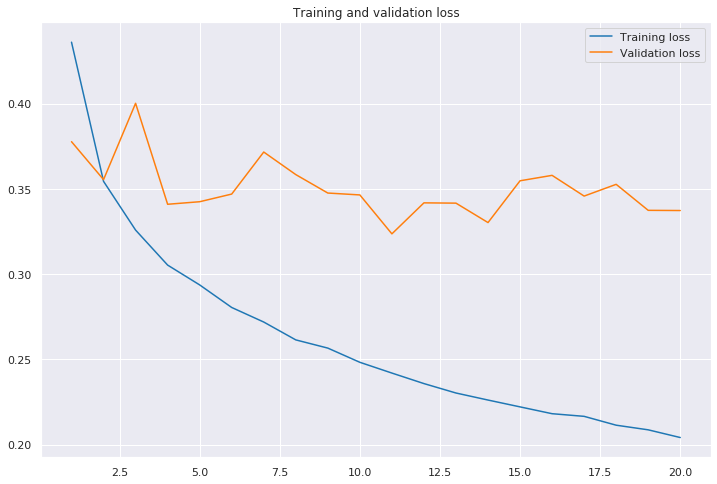

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

NOTE: Was diverging for me.  Had to reduce lr by 1 order of magnitude in order to get similar results to those
shown in textbook.

Since we are using MAE for the loss, we can directly compare the training and validation loss (MAE) here to
our naive results.  Some of the validation MAE/loss get closs to the 0.29 naive result (though not quite
there for me when I tried it).  Good discussion in textbook here.  If there is a simple naieve solution, why doesn't
the model find it?  The same could be asked for the Titanic dataset results most of the students saw.  The simple
solution is within the space of models defined by this fully connected model.  

This is a pretty significant limitation of ML in general:

**Conclusion**: unless the learning altorighm is hardcoded to look for a specific model, parameter learning can
sometimes fail to find a simple solution to a simple problem.


# 6.3.5 A first recurrent baseline

The first fully connected NN did not achieve the naive baseline performance.  The previous example flattned the
timeseries, which removed the notion of time from the input data.

Let's use RNN approach so we can preserve this sequence information, where causality and order matter.

We introduce the GRU layer (Gated Recurrent Unit).  It uses same principle as LSTM but somewhat more streamlined.
The streamlining may mean GRU doesn't have quite as much representational power as an LSTM.  But there is always
a tradeoff between representational power and computational effort in machine learning models.

In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

This should show better results.  We can significantly beat the common-sense baseline with this recurrent
model.  We achieve a MAE/loss of around 0.265.  The model immediately begins to overfit as well, indicating we
can regularize it and maybe push it even further.  This MAE translates to an error of 2.35 degrees Celcius after
denormalizing it.  This is a solid gain from before.

### 6.3.6 Using recurrent dropout to fight overfitting

It is evident from the MAE/loss that we overfit almost immediately.  Thus we should try and use some regularization
to fight this and improve our prediction ability.  

It is not an easy question of how to apply dropout regularization to a recurrent network.  Recent results have
shown that it can be done.  In short, we need to use the same dropout mask for all time steps of the recurrent
calculation.

Because of this need for the dropout mask to be preserved in time, we can't use a separate dropout layer, as we
conceputally can with straightforward feedforward networks.  Thus recurrent layers need to support
dropout regularization directly (in current Keras conceptualizations of layers).

Every recurrent layer in Keras has 2 dropout related arguments.  `dropout`, a float specifying the dropout
rate for input units of the layer, and `recurrent_dropout` specifying the dropout rate of the recurrent units.
Let's add droput and recurrent dropout to the GRU layer and see how it impacts the overfitting we observed. 

Because dropout can slow down the rate of convergence, we need to train the models longer now.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

Once again plotting the MAE/loss shows the results.  Success! We are no longer overfitting.  The loss/mae appears
to continue to be reduced over 40 generations, and achieves a best MAE of 0.26.

Although we seem to have stopped overfitting, our best validation scores haven't improved too much yet.

### 6.3.7 Stacking recurrent layers

Because we are no longer overfitting but seem to have hit a performance bottleneck, we should consider
increasing the capacity of the network.  

It is generally a good idea to increase the capacity of your network until overfitting becomes the
primary obstacle.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full
sequence of outputs (a 3D tensor).



In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# 6.3.8 Using Bidirectional RNNs

By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a
unidirectional RNN.

For some types of tasks (like many natural languages), it turns out that the forward chronological order is
a bit arbitrary.  Or another way to put it, there are also patterns that can be learned if you go backward in
time, from the last words spoken to the first.  

We can easily create a generate in Python that yields the word orders in reverse order, and thus see if we train
with the sentences reversed how well the system can learn.  (We use -1 step size to reverse the sample
sequences).

Training the same one-GRU-layer network we used in 6.3.5, using a generator, yields the following results:

In [ ]:
def generator_rev(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    '''Generator for a "data" timeseries.  Yields a generator that returns the chronolgical sequences
    in reverse order.
    
    Parameters
    ----------
    data - The original array of floating-pont data (after being normalized)
    lookback - How many timesteps back the input data should go
    delay - How many timesteps in the future the target should be
    min_index and max_index - Indices in the data array that delimit which timesteps to draw from.
      This is useful for keeping a segment of the data for validation and another for testing.
    shuffle - Whether to shuffle the samples or draw them in chronological order.
    batch_size - The number of samples per batch.
    step - The period, in timesteps, at which you sample data.  You'll set it to 6 in order to draw
      one data point every hour.    
  
    Returns
    -------
    Returns a numpy array of the input samples shape (batch_size, lookback//step, num_features) and another numpy array of
    the targets of shape (batch_size,)
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(
                     min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        # empty numpy array to gather and return the resulting samples we select
        samples = np.zeros((len(rows), 
                           lookback // step,
                           data.shape[-1]))
        
        # likewise, empty array to hold the resulting targets to be returned
        targets = np.zeros((len(rows),))
        
        # rows have been slected (either random or the next batch), extract the input samples and output targets
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            #print(indices)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples[:, ::-1, :], targets

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_rev_gen = generator_rev(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_rev_gen =   generator_rev(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step=step,
                      batch_size=batch_size)

test_rev_gen =  generator_rev(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step=step,
                      batch_size=batch_size)

# how many steps to draw from val_gen in order to see 
# the entire validation set
# NOTE: looks like bug in book, if you don't divide by batch_size, you will draw WAY too many samples
# to complete a validation
val_steps = (300000 - 200001 - lookback) // batch_size

# how many steps to draw from test_gen in order to see
# the entire test set
# NOTE: ditto, need to divide by batch_size or else draw many more items from test than needed
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In this case, the reversed-order GRU strongly underperforms even the common-sense baseline,
indicating that in this case, chronological process is important to the success of the approach.

But in this case, we are using the whether data, which is strongly chronological, so we shouldn't
be surprised that looking at data in reverse makes it harder to predict the trends.

But lets try the same idea on the LSTM IMDB example from section 6.2.  Here we are again training
the same LSTM, just using data where the review word order has been reversed.

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

In [ ]:
# maximum number of words to consider as features
max_features = 10000

# Cuts texts off after this number of words
maxlen = 500

# load the data and reverse the sequences
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)

# reverse the sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# pad the sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In this case you should observe that you get performance nearly identical to that of the chronolgicaly correct
ordered LSTM we trained before on the same data.

Remarkably, reversed-order processing works just as well as regular chronological order on the natural
language reviews.  This confirms idea that, although word order *does* matter in understanding
language, *which* order you use isn't crucial.  Importantly RNN trained on reversed sequences will
learn different representations.

In ML representations that are *different* yet *useful* are always worth exploiting.  The more they differ, the better, they offer new insights into the problem being modeled.  This is the intuition behind *ensembling*
that is looked at in chapter 7.

A bidirectional RNN exploits this idea to improve on the performance on some kinds of tasks.  

In Keras we use the `Bidirectional` layer.

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split = 0.2)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

It performs slightly better than the regular `LSTM` you tried previously, achieving 89% validation accuracy.
It seems to overfit more quickly.  With some regularization, the bidirectional approach would
likely be a strong performre on this task.

Now let's try the same approach on the temperature-prediction data task.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [ ]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The performs about as well as the regular GRU layer.  We don't get much, if any, benefit from the bidirectional
presentation, which should not be surprising.

### 6.3.9 Going even further

There are many other things you could try in order to improve performance on the temperature-forcasting problem:

- Adjust number of units in each recurrent layer (may be more optimal layer sizes)
- Adjust the learning rate
- Try using LSTM instead of GRU layers
- Try using a bigger densly connected regressor on top of the recurrent layers.  Maybe even a small stack of `Dense`
  layers.
- Don't forget to run your best meta-parameters eventually on the test set!

### 6.3.10 Wrapping
- First establish common-sense baselines of model/system you are tackeling.
- Try simple models before expensive ones.
- When temporal ordering matters, recurrent networks are the way to go.
- To use dropout with recurrent networks, in Keras use time-constant dropout mask and/or recurrent dropout mask.
- Stacked RNNs provide more power, but are more expensive.
- Bidirectional RNNs look at sequences in both directions.
  - They are useful on NLP problems.
  - But aren't strong on sequences where recent past is much more informative than the beginning of the sequence.

## 6.4 Sequence processing with convnets

Time can be treated as a spacial dimension, like
width or height.  

1D convnets can be competitive with RNNs on certain
sequence-processing problems, and usually at a 
consideradbly cheaper computational cost.

### 6.4.1 Understanding 1D convolution for sequence data

In the same way we convolve over 2D image data,
we can convolve over a sequence by treating it
as a 1D array, and colvolving patches or windows
along the sequence.  Each patch is then processed
as a subsequence.

1D convolution layers can recognize local patterns
in a sequence.  

### 6.4.2 1D pooling for sequence data

Keras has a 1D convnet layer.  It also has a 1D
pooling layer, which can be used in equivalent
way as 2D case to downsample and reduce the length
of 1D inputs (*subsampling*).  This is particularly useful for very long sequence data, to create a preprocessing step find small subsequences, that can
then later be analyzed by a full-blown recurrent layer.

### 6.4.3 Implementing a 1D convnet

In Keras, we use `Conv1D` layer for 1D convolutional
networks.  It takes as input 3D tensors with shape
`(samples, time, features)` and returns
similarly shaped 3D tensors.  The convolution window
is a 1D window on the temporal axis: axis 1 in the
input tensor.

Let's build a simple two-layer 1D convnet and
apply it to the IMDB sentiment classification task.


In [ ]:
# obtain the imdb train/test data once again
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

1D convnets are typically structured same way
as we did with 2D counterparts, with alternating
layers of `Conv1D` and `MaxPooling1D`, ending
in either a global pooling layer or a `Flatten`
layer that turn the 3D outputs into 2D outputs.
We then usually use 1 or more `Dense` fully
connected layers to create a classifier
or regression on the extracted information.

One difference, we can use larger convolution windows
with 1D convnets.

Here is a 1D convnet model for the IMDB dataset.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

In [ ]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Below are the training and validation loss and
accuracy results.  You should find that accuracy
is a bit less than the LSTM from previously, but
runtime/training time is faster.


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### 6.4.4 Combining CNNs and RNNs to process long sequences

Because 1D convnets process input patches
independently, they are not sensitive to the
order of the timesteps, unlike RNNs.  To process
longer range sequences, you could stack on 1D
convnets and pooling layers.  But this is still
fairly week way to induce order sensitivity.

For example, if we try a stack of 1D convnets
on the temperature-forecasting problem, where
order-sensitivity is key to producing good predictions, you will find that performance is
very bad.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [ ]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The validation MAE stays in the 0.40s: we can't even
beat the common-sense baseline using the small 1D
convnet.

But one strategy is to combine the speed and 
lightness of convnets with the order-sensitivity
of RNN's, using the 1D convnet as a preprocessing
step before an RNN.  This is especially beneficial
if dealing with very long sequences that can't be 
realistically processed with RNNs.  The convnet
will turn the long input sequence into much shorter
(downsampled) sequences of higher-level features.

In [ ]:
# previously set to 6, now 3 (1 point per 30 min)
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step=step)

test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step=step)


We use a model starting with two Conv1D layers
for preprocessing, followed by a GRU layer.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [ ]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

Judging from the validation loss, this setup isn't
as good as the regularized GRU alone, but it's
significantly faster.  It looks at twice as much
data, which doesn't appear to help in this case, but
can be very helpful for other datasets.

### 6.4.5 Wrapping up

- In same way 2D convnets perform well for visual
  patterns in 2D space, 1D convnets perform well for
  processing temporal (1D) patterns.
  - And they are often faster alternatives to RNNs.
- 1D convnets are structured typically like their 
  2D image processing equivalents, layers of 
  `Conv1D` followed by 1D pooling layers, ending
  with a global pooling or flattening operation.
- Because RNNs can be expensive, but 1D convnets are
  much cheapter computationally, it can be a good
  strategy to prepreocess with a few layers of 1D
  convnets before using a RNN.

### Chapter Summary

- This chapter was about processing sequence and
  time series data
  - Tokenize text
  - Word embeddings and embedding spaces
  - What are recurrent networks and how they work
  - How to stack RNN layers
  - What are bidirectional RNN and when and for
    what types of series data are they useful.
  - How to use 1D convents for sequence processing
  - How to combine 1D convnets and RNNs to process
    long sequences.
- You can use RNNs for timeseries regressions
  ("predicting the future"), timeseries classification,
  anomaly detection in timeseries, and sequence
  labeling.
- Similarly, you can use 1D convnets for machine
  translation (sequence-to-sequence convolutional models),
  document classification and spelling correction.
- If *global order matters* in your sequence data,
  then it's preferable to use a recurrent network
  to process it.  This is typically the case for
  timeseries, where the recent past is likely to be
  more informative than the distant past.
- If *global ordering isn't fundamentally meaningful*
  then 1D convnets will turn out to work at least
  as well and are computationally cheaper.  This is
  often the case for text data.